---
layout: post
title: Performance shootout - python libraries for computer vision (Part 2/2)
excerpt: Did a little performance comparison for different image processing/computer vision libraries for computing different kinds of features from image
---

**Update 2017-02-03**

Updated to latest versions of opencv/mahotas/skimage

## 1. Boilerplate Stuff

Like before, we'll define some basic functions for plotting. Also specifying some image paths (modify them as necessary)

In [1]:
import os, random
import numpy as np
import timeit
import cv2, mahotas, skimage, skimage.feature, skimage.measure
from skimage.feature import local_binary_pattern
from mahotas.features.lbp import lbp_transform

import matplotlib.pyplot as plt
%matplotlib inline

ImagePath = '/home/kampta/data/brodatz/'

def pyplots(images, titles=None):
    num = len(images)
    plt.figure(figsize=(15,6))
    for index, im in enumerate(images):
        plt.subplot(2, num/2, index+1)
        plt.imshow(im, cmap='gray')
        if titles is None:
            plt.title('%d'%(index))
        else:
            plt.title(str(titles[index]))
        plt.axis('off')
        
def kNN(srcVec, destVecs, k=7, method=cv2.HISTCMP_CORREL, absolute=True, reverse=False):
    distances = []
    srcVec = srcVec.flatten().astype(np.float32)
    for destVec in destVecs:
        distance = cv2.compareHist(srcVec, destVec.flatten().astype(np.float32), method=method)
        distances.append(distance)
    
    if absolute:
        distances = np.absolute(distances)
        
    if reverse:
        sortedIdx = np.argsort(distances)[-k:][::-1]
    else:
        sortedIdx = np.argsort(distances)[:k]
        
    return sortedIdx, [distances[idx] for idx in sortedIdx]

### Sample Images

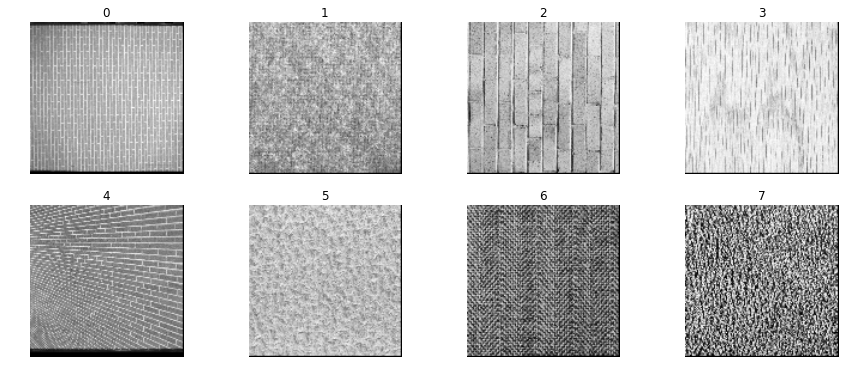

In [2]:
images = os.listdir(ImagePath)

testIdx = 40
testImg = mahotas.imresize(mahotas.imread(os.path.join(ImagePath,images[testIdx])), (128,128)).astype(np.int32)
allImg = [mahotas.imresize(mahotas.imread(os.path.join(ImagePath,im)), (128, 128)).astype(np.int32) for im in images]

sample = random.sample(allImg,8)
pyplots(sample)

## haralick features

### mahotas

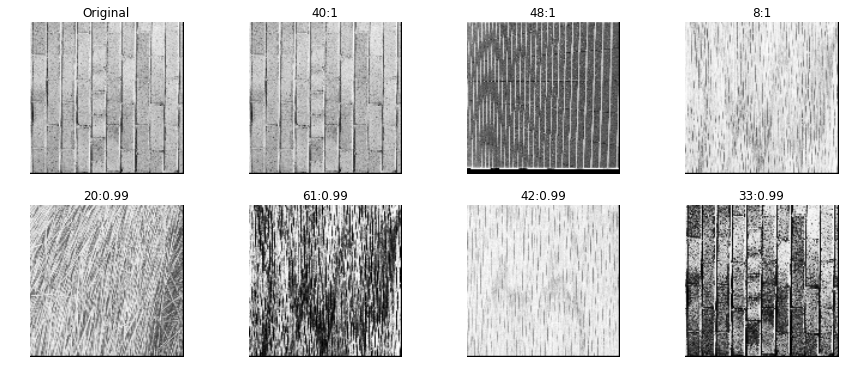

In [3]:
inVector = mahotas.features.haralick(testImg)
allVectors = [mahotas.features.haralick(img) for img in allImg]

nn, distances = kNN(inVector, allVectors, reverse=True)

pyplots([testImg] + [allImg[idx] for idx  in nn], 
        titles=['Original']+['%d:%.2g'%(idx, distance) for idx,distance in zip(nn,distances)])

### skimage

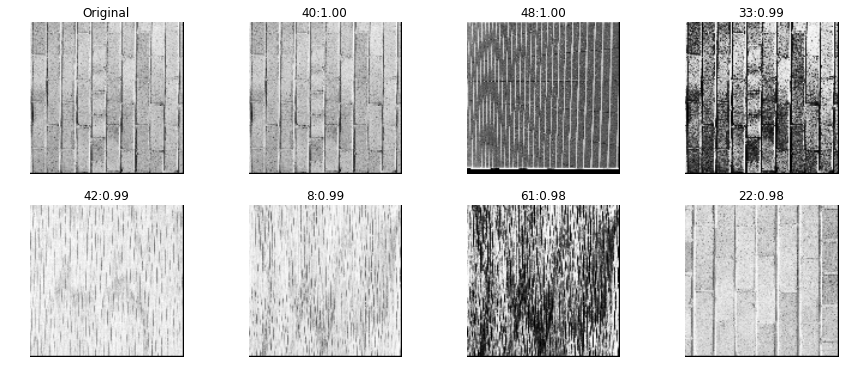

In [4]:
def haralick_sk(img):
    g = skimage.feature.greycomatrix(img, range(4), np.pi/4*np.arange(4), levels=256, symmetric=True, normed=True)
    return skimage.feature.greycoprops(g)
    
inVector = haralick_sk(testImg)
allVectors = [haralick_sk(img) for img in allImg]

nn, distances = kNN(inVector, allVectors, reverse=True)

pyplots([testImg] + [allImg[idx] for idx  in nn], 
        titles=['Original']+['%d:%.2f'%(idx, distance) for idx,distance in zip(nn,distances)])

## zernike moments

### mahotas

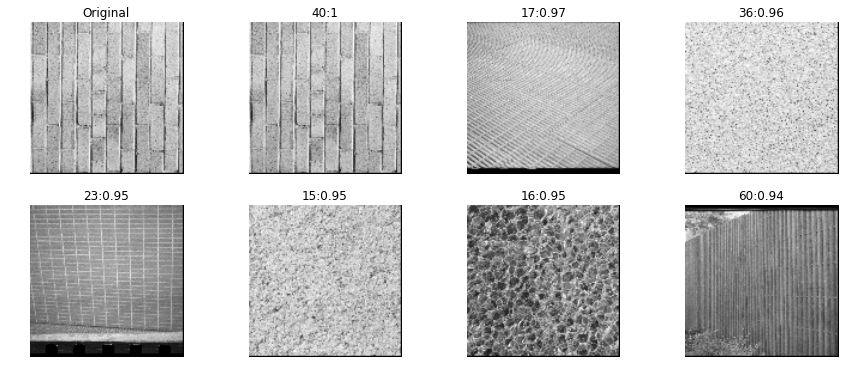

In [5]:
inVector = mahotas.features.zernike_moments(testImg, radius=5)
allVectors = [mahotas.features.zernike_moments(img, radius=5) for img in allImg]

nn, distances = kNN(inVector, allVectors, reverse=True)

pyplots([testImg] + [allImg[idx] for idx  in nn], 
        titles=['Original']+['%d:%.2g'%(idx, distance) for idx,distance in zip(nn,distances)])

## hu moments

### skimage

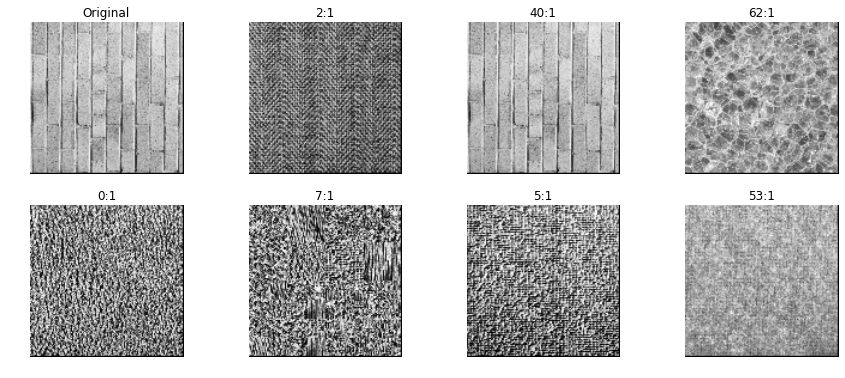

In [6]:
def hu_moments_sk(img):
    img = img.astype(np.uint8)
    raw_m = skimage.measure.moments(img)
    cr = raw_m[0, 1] / raw_m[0, 0]; cc = raw_m[1, 0] / raw_m[0, 0]
    central_m = skimage.measure.moments_central(img, cr, cc)
    norm_m = skimage.measure.moments_normalized(central_m)
    return skimage.measure.moments_hu(norm_m)

inVector = hu_moments_sk(testImg)
allVectors = [hu_moments_sk(img) for img in allImg]

nn, distances = kNN(inVector, allVectors, reverse=True)

pyplots([testImg] + [allImg[idx] for idx  in nn], 
        titles=['Original']+['%d:%.2g'%(idx, distance) for idx,distance in zip(nn,distances)])

### opencv

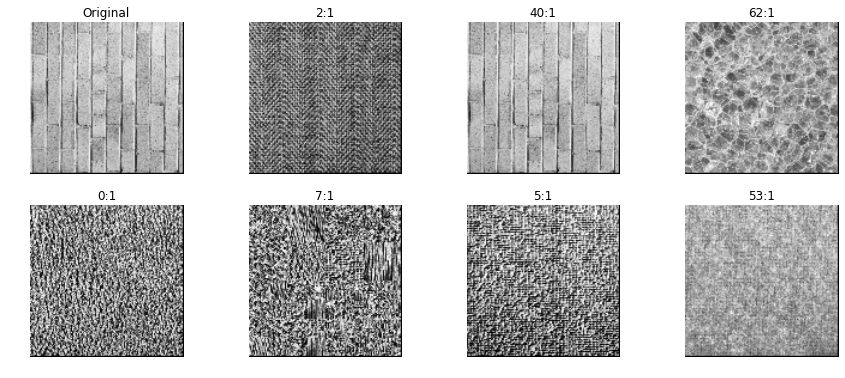

In [7]:
def hu_moments_cv(img):
    img = img.astype(np.uint8)
    m = cv2.moments(img)
    return cv2.HuMoments(m)

inVector = hu_moments_cv(testImg)
allVectors = [hu_moments_cv(img) for img in allImg]

nn, distances = kNN(inVector, allVectors, reverse=True)

pyplots([testImg] + [allImg[idx] for idx  in nn], 
        titles=['Original']+['%d:%.2g'%(idx, distance) for idx,distance in zip(nn,distances)])

## local binary patterns

### mahotas

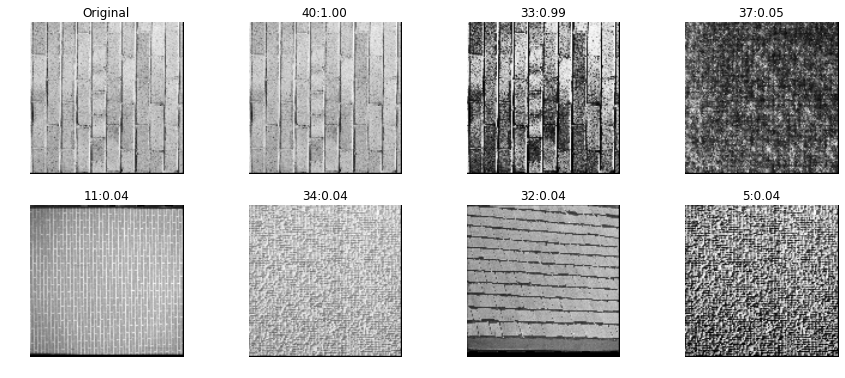

In [18]:
inVector = lbp_transform(testImg, radius=2, points=16)
allVectors = [lbp_transform(img, radius=2, points=16) for img in allImg]

nn, distances = kNN(inVector, allVectors, reverse=True)

pyplots([testImg] + [allImg[idx] for idx  in nn], 
        titles=['Original']+['%d:%.2f'%(idx, distance) for idx,distance in zip(nn,distances)])

### skimage

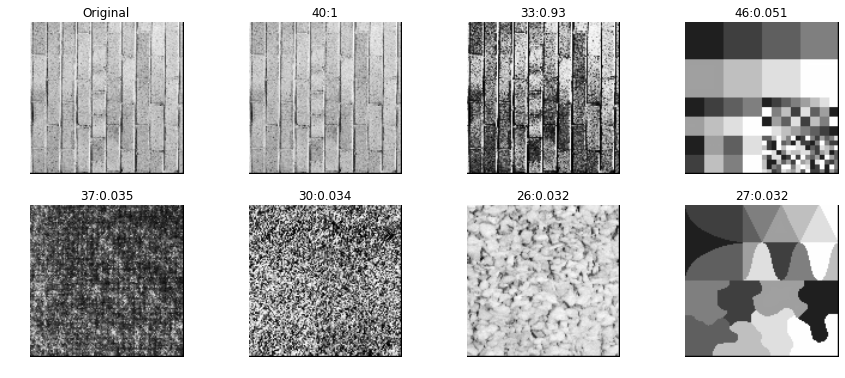

In [19]:
inVector = local_binary_pattern(testImg, 16, 2, 'uniform')
allVectors = [local_binary_pattern(img, 16, 2, 'uniform') for img in allImg]

nn, distances = kNN(inVector, allVectors, reverse=True)

pyplots([testImg] + [allImg[idx] for idx  in nn], 
        titles=['Original']+['%d:%.2g'%(idx, distance) for idx,distance in zip(nn,distances)])

## mahotas vs skimage vs opencv

In [15]:
pre ='''
import os
import numpy as np
import cv2, mahotas, skimage, skimage.feature, skimage.measure
from skimage.feature import local_binary_pattern
from mahotas.features.lbp import lbp_transform

ImagePath = '/home/kampta/data/brodatz/'
images = os.listdir(ImagePath)
testImg = mahotas.imresize(mahotas.imread(os.path.join(ImagePath,images[40])), (128,128)).astype(np.int32)
testImg8 = testImg.astype(np.uint8)

def haralick_sk(img):
    g = skimage.feature.greycomatrix(img, range(4), np.pi/4*np.arange(4), levels=256, symmetric=True, normed=True)
    return skimage.feature.greycoprops(g)
    
def hu_moments_sk(img):
    raw_m = skimage.measure.moments(img)
    cr = raw_m[0, 1] / raw_m[0, 0]; cc = raw_m[1, 0] / raw_m[0, 0]
    central_m = skimage.measure.moments_central(img, cr, cc)
    norm_m = skimage.measure.moments_normalized(central_m)
    return skimage.measure.moments_hu(norm_m)
    
def hu_moments_cv(img):
    m = cv2.moments(img)
    return cv2.HuMoments(m)

'''

In [16]:
def t(s):
    return timeit.timeit(s, setup=pre, number=10)

tests = [
    ('haralick', [
        'mahotas.features.haralick(testImg)',
        'haralick_sk(testImg)',
        None,
        ]),
    ('zernike', [
        'mahotas.features.zernike_moments(testImg, radius=5)',
        None,
        None,
        ]),
    ('hu', [
        None,
        'hu_moments_sk(testImg8)',
        'hu_moments_cv(testImg8)',
        ]),
    ('lbp', [
        'lbp_transform(testImg, radius=3, points=24)',
        'local_binary_pattern(testImg, 24, 3, "uniform")',
        None,
        ]),
]

print r'%-12s|%9s |%9s |%9s |' % ('Algorithm', 'mahotas','skimage','opencv')
for name,statements in tests:
    print r'%-12s|' % name,
    for st in statements:
        if st is None:
            print '      NA |',
        else:
            time = '%.4f' % (t(st))
            print '%8s |' % time,
    print


Algorithm   |  mahotas |  skimage |   opencv |
haralick    |   0.1682 |   0.1389 |       NA |
zernike     |   0.0104 |       NA |       NA |
hu          |       NA |   0.0078 |   0.0002 |
lbp         |   0.1810 |   0.0663 |       NA |


In [ ]:
mahotas vs skimage - Local Binary Patterns